In [3]:
!pip install tensorflow==2.3.0

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.utils import class_weight


In [5]:
train_path = '/content/drive/MyDrive/Colab Notebooks/data_covid/NonAugmentedTrain'
val_path = '/content/drive/MyDrive/Colab Notebooks/data_covid/ValData'

In [6]:
num_classes_train = len(os.listdir(train_path))
print("There are %d classes in the train dataset." %num_classes_train)

There are 4 classes in the train dataset.


In [7]:
num_classes_val = len(os.listdir(val_path))
print("There are %d classes in the validation dataset." %num_classes_val)

There are 4 classes in the validation dataset.


In [8]:
##  we'll explore more of the train dataset..

BP_path = '/content/drive/MyDrive/Colab Notebooks/data_covid/NonAugmentedTrain/BacterialPneumonia'
img_list_bp = os.listdir(BP_path)

print('There are %d images of Bacterial Pneumonia present in the Train dataste.' %(len(img_list_bp)))

There are 650 images of Bacterial Pneumonia present in the Train dataste.


In [9]:
covid_path = '/content/drive/MyDrive/Colab Notebooks/data_covid/NonAugmentedTrain/COVID-19'
img_list_covid = os.listdir(covid_path)

print('There are %d images of COVID-19 present in the Train dataste.' %(len(img_list_covid)))

There are 60 images of COVID-19 present in the Train dataste.


In [10]:
normal_path = '/content/drive/MyDrive/Colab Notebooks/data_covid/NonAugmentedTrain/Normal'
img_list_normal = os.listdir(normal_path)

print('There are %d images of Normal lung present in the Train dataste.' %(len(img_list_normal)))

There are 880 images of Normal lung present in the Train dataste.


In [11]:
VP_path = '/content/drive/MyDrive/Colab Notebooks/data_covid/NonAugmentedTrain/ViralPneumonia'
img_list_vp = os.listdir(VP_path)

print('There are %d images of Viral Pneumonia present in the Train dataste.' %(len(img_list_vp)))

There are 412 images of Viral Pneumonia present in the Train dataste.


In [12]:
batch_size = 32
image_size = (224, 224)

In [13]:
train_gen = ImageDataGenerator(                                                            
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                preprocessing_function=preprocess_input,
                                fill_mode='nearest')

In [14]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [15]:
train_ds = train_gen.flow_from_directory(train_path,
                                         target_size=image_size,
                                         class_mode='sparse',
                                         batch_size=batch_size,
                                         shuffle=True)

Found 2002 images belonging to 4 classes.


In [16]:
images, labels = next(iter(train_ds))
print(images.shape, labels.shape)

(32, 224, 224, 3) (32,)


In [17]:
val_ds = val_gen.flow_from_directory(val_path,
                                     target_size=image_size,
                                     class_mode='sparse',
                                     batch_size=batch_size,
                                     shuffle=True)

Found 988 images belonging to 4 classes.


In [18]:
num_classes = train_ds.num_classes
num_classes

4

In [19]:
train_ds.class_indices

{'BacterialPneumonia': 0, 'COVID-19': 1, 'Normal': 2, 'ViralPneumonia': 3}

In [20]:
class_labels = list(train_ds.class_indices.keys())
class_labels


['BacterialPneumonia', 'COVID-19', 'Normal', 'ViralPneumonia']

In [21]:
## defining the  base Vgg16 model..

img_shape = image_size + (3,)

basemodel_vgg16 = VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=img_shape)

58892288/58889256 [==============================] - 0s 0us/step


In [22]:
basemodel_vgg16.trainable = False

In [23]:
basemodel_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [24]:
## Constructing a new model by adding the classification layer on top of the base model 

x = basemodel_vgg16.output
x = Flatten(name="flatten")(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(num_classes, activation='softmax')(x)

#define new model
model = Model(inputs=basemodel_vgg16.input, outputs=output)

In [25]:
base_lr = 0.0001

model.compile(optimizer= Adam(lr=base_lr),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [26]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [27]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                classes=np.unique(train_ds.classes), 
                y=train_ds.classes)
train_class_weights = dict(enumerate(class_weights))

print(train_class_weights)

{0: 0.77, 1: 8.341666666666667, 2: 0.56875, 3: 1.2148058252427185}


In [28]:
## lets train the model with the new added classifier for 10 epochs

init_epoch = 10

history = model.fit(train_ds,
                    steps_per_epoch=len(train_ds),
                    epochs=init_epoch,
                    validation_data=val_ds,
                    validation_steps=len(val_ds),
                    class_weight=train_class_weights)

Epoch 1/10
63/63 [==============================] - 574s 9s/step - loss: 4.7858 - accuracy: 0.5739 - val_loss: 1.3642 - val_accuracy: 0.7662
Epoch 2/10
63/63 [==============================] - 49s 779ms/step - loss: 2.1507 - accuracy: 0.6643 - val_loss: 1.4925 - val_accuracy: 0.7490
Epoch 3/10
63/63 [==============================] - 49s 773ms/step - loss: 1.5174 - accuracy: 0.6703 - val_loss: 1.1074 - val_accuracy: 0.7298
Epoch 4/10
63/63 [==============================] - 48s 767ms/step - loss: 1.2337 - accuracy: 0.6698 - val_loss: 0.8096 - val_accuracy: 0.7561
Epoch 5/10
63/63 [==============================] - 49s 773ms/step - loss: 0.8249 - accuracy: 0.6998 - val_loss: 0.7120 - val_accuracy: 0.7763
Epoch 6/10
63/63 [==============================] - 48s 767ms/step - loss: 0.7533 - accuracy: 0.7068 - val_loss: 0.7218 - val_accuracy: 0.7561
Epoch 7/10
63/63 [==============================] - 48s 766ms/step - loss: 0.7283 - accuracy: 0.7163 - val_loss: 0.7282 - val_accuracy: 0.7601
E

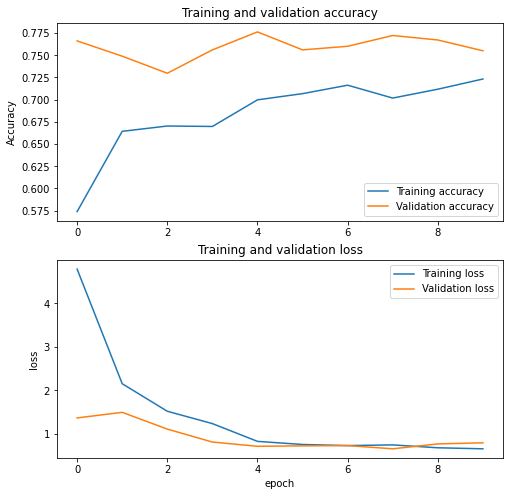

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.ylabel("Accuracy")
#plt.ylim([min(plt.ylim()),1])
plt.title("Training and validation accuracy")

plt.subplot(2,1,2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel("loss")
#plt.ylim(0,1.0)
plt.title("Training and validation loss")
plt.xlabel('epoch')
plt.show()

In [30]:
## lets do some fine tuning to see whether we can improve the model's accuracy

In [31]:
# Let's take a look to see how many layers are in the base model vgg16

print("Number of layers in the base model: ", len(basemodel_vgg16.layers))

Number of layers in the base model:  19


In [32]:
## lets check out the layers by name and the layers are trainable or not..

for i , layer in enumerate(basemodel_vgg16.layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [33]:
## lets start fine tune from #15(i.e from block5)

fine_tune_at = 15

for layer in basemodel_vgg16.layers[:fine_tune_at]:
  layer.trainable = False

for layer in basemodel_vgg16.layers[fine_tune_at:]:
  layer.trainable = True

In [34]:
## lets recompile the model

base_lr = 0.00001

model.compile(optimizer= Adam(lr=base_lr),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [35]:
fine_tune_epoch = 35

filepath_checkpoint = 'VGG16_model_w_classWgt.h5'

checkpoint = ModelCheckpoint(filepath_checkpoint,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=10,
                           mode='max')

callbacks_list = [checkpoint, early_stop]

history_tuned = model.fit(train_ds,
                          class_weight=train_class_weights,
                          steps_per_epoch=len(train_ds),
                          epochs=fine_tune_epoch,
                          initial_epoch=history.epoch[-1],
                          shuffle=True,
                          validation_data=val_ds,
                          validation_steps=len(val_ds),                                    
                          callbacks=callbacks_list) 

Epoch 10/35
63/63 [==============================] - ETA: 0s - loss: 0.5823 - accuracy: 0.7408
Epoch 00010: val_accuracy improved from -inf to 0.75506, saving model to VGG16_model_w_classWgt.h5
63/63 [==============================] - 50s 799ms/step - loss: 0.5823 - accuracy: 0.7408 - val_loss: 0.7590 - val_accuracy: 0.7551
Epoch 11/35
63/63 [==============================] - ETA: 0s - loss: 0.5524 - accuracy: 0.7502
Epoch 00011: val_accuracy improved from 0.75506 to 0.76012, saving model to VGG16_model_w_classWgt.h5
63/63 [==============================] - 50s 789ms/step - loss: 0.5524 - accuracy: 0.7502 - val_loss: 0.7513 - val_accuracy: 0.7601
Epoch 12/35
63/63 [==============================] - ETA: 0s - loss: 0.5600 - accuracy: 0.7418
Epoch 00012: val_accuracy did not improve from 0.76012
63/63 [==============================] - 49s 776ms/step - loss: 0.5600 - accuracy: 0.7418 - val_loss: 0.6953 - val_accuracy: 0.7389
Epoch 13/35
63/63 [==============================] - ETA: 0s - 

In [36]:
acc += history_tuned.history['accuracy']
val_acc += history_tuned.history['val_accuracy']

loss += history_tuned.history['loss']
val_loss += history_tuned.history['val_loss']

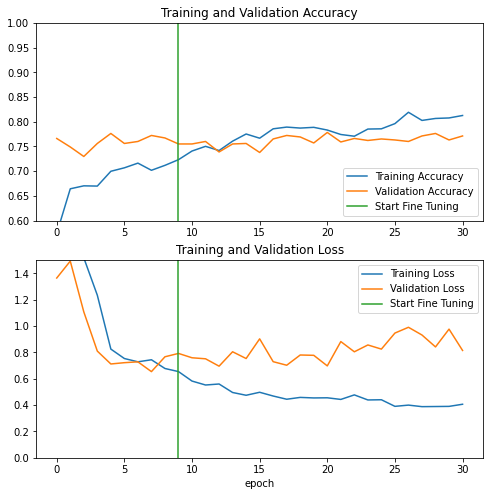

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([init_epoch-1,init_epoch-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])
plt.plot([init_epoch-1,init_epoch-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
model = keras.models.load_model('VGG16_model_w_classWgt.h5')

In [39]:
#class_names = ['BacterialPneumonia', 'COVID-19','Normal','ViralPneumonia']
import tensorflow as tf

test_img = keras.preprocessing.image.load_img('/content/drive/MyDrive/Colab Notebooks/data_covid/NonAugmentedTrain/BacterialPneumonia/148.jpeg', target_size=(224,224)) 
img = keras.preprocessing.image.img_to_array(test_img)
img = preprocess_input(img)
img = tf.expand_dims(img, 0)

prediction = model.predict(img)
score = tf.nn.softmax(prediction[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence."
       .format(class_labels[np.argmax(score)], 100*np.max(score))      
      )

This image most likely belongs to BacterialPneumonia with a 45.31 percent confidence.


In [40]:
## classification report

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(val_path,
                                       target_size=image_size,
                                       class_mode='sparse',
                                       batch_size=batch_size,
                                       shuffle=False)

test_steps_per_epoch = len(test_ds)

predictions = model.predict(test_ds, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_ds.classes
test_class_labels = list(test_ds.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=test_class_labels)
print(report)    




Found 988 images belonging to 4 classes.
                    precision    recall  f1-score   support

BacterialPneumonia       0.69      0.75      0.72       324
          COVID-19       0.64      0.78      0.70         9
            Normal       0.86      1.00      0.93       450
    ViralPneumonia       0.67      0.33      0.44       205

          accuracy                           0.78       988
         macro avg       0.71      0.72      0.70       988
      weighted avg       0.76      0.78      0.76       988



In [41]:
## lets plot the confusion matrix

In [42]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot   

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    #import matplotlib.pyplot as plt
    #import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

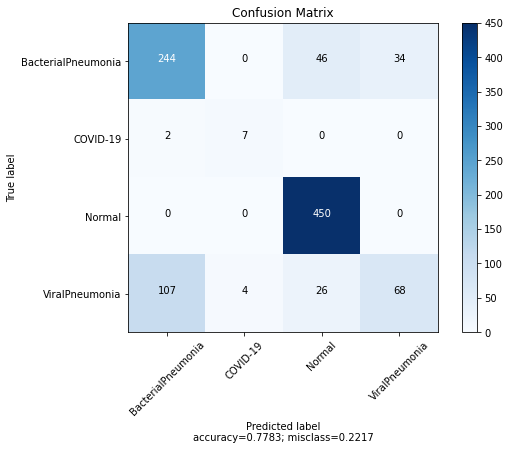

In [43]:
prediction = model.predict(test_ds)
y_pred = np.argmax(prediction, axis=1)

cm = confusion_matrix(true_classes, y_pred)

plot_confusion_matrix(cm,          
                      normalize    = False,
                      target_names = test_class_labels,
                      title        = "Confusion Matrix")